# Oak Wilt Data Quality Assessment

This notebook analyzes the quality of oak wilt disease observations data, with special focus on coordinate validation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

## 1. Load and Inspect the Data

In [2]:
# Load the data
df = pd.read_csv('2024-10-16full_data_set_with_final corrected file_17456.csv')
print(f"Loaded {len(df)} records from the dataset")

# Display basic dataset info
print(f"Number of fields: {len(df.columns)}")
df.info()

Loaded 17456 records from the dataset
Number of fields: 80
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17456 entries, 0 to 17455
Data columns (total 80 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17456 non-null  int64  
 1   KEY         17456 non-null  object 
 2   objectid    17456 non-null  int64  
 3   reporter    17456 non-null  object 
 4   RecOwner    17456 non-null  object 
 5   SciName     17456 non-null  object 
 6   ComName     17456 non-null  object 
 7   Nativity    17456 non-null  object 
 8   OccStatus   17456 non-null  object 
 9   Status      17456 non-null  object 
 10  ObsDate     16533 non-null  object 
 11  DateEnt     17456 non-null  object 
 12  DateUp      17456 non-null  object 
 13  Location    17456 non-null  object 
 14  County      17456 non-null  object 
 15  COUNTY      17456 non-null  object 
 16  STATE       17456 non-null  object 
 17  Latitude    17370 non-null  float64
 18  Longitu

/var/folders/cr/vqtxh7m93x3b4vqrzyk50p8c0000gn/T/ipykernel_8511/2803178740.py:2: DtypeWarning: Columns (28,35,36,40,50,56,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2024-10-16full_data_set_with_final corrected file_17456.csv')


In [3]:
# View the first few records
df.head()

,Unnamed: 0,KEY,objectid,reporter,RecOwner,SciName,ComName,Nativity,OccStatus,Status,...,Locality,Comments,ReviewDate,Reviewer,VerifyMthd,Verified,IDCred,ReviewComm,lat,lng
0,1,Adair_Iowa,3963873,US Forest Service Forest Health Protection,Federal Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,NaN,NaN,NaN,NaN,NaN,Verified,NaN,NaN,41.3307,-94.471
1,2,Adair_Iowa,5128725,US Forest Service Forest Health Protection,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,NaN,NaN,NaN,NaN,NaN,Verified,NaN,NaN,41.3307,-94.471
2,3,Adair_Iowa,5132898,US Forest Service Forest Health Protection,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,NaN,NaN,NaN,NaN,NaN,Verified,NaN,NaN,41.3307,-94.471
3,4,Adair_Iowa,5128046,US Forest Service Forest Health Protection,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,NaN,NaN,NaN,NaN,NaN,Verified,NaN,NaN,41.3307,-94.471
4,5,Adair_Iowa,5130542,US Forest Service Forest Health Protection,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,NaN,NaN,NaN,NaN,NaN,Verified,NaN,NaN,41.3307,-94.471


## 2. Check for Missing Values

In [4]:
# Check overall missing values
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100

# Combine into a DataFrame for easier viewing
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
}).sort_values('Missing Values', ascending=False)

# Only show fields with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

print(f"Found {len(missing_df)} columns with missing values")
missing_df.head(20)  # Show top 20 fields with missing values

Found 62 columns with missing values


,Missing Values,Percentage
Substrate,17456,100.0
QuantityU,17456,100.0
DateAcc,17456,100.0
Percentcov,17456,100.0
APPXQuant,17456,100.0
NumCollect,17456,100.0
Abundance,17456,100.0
Centroid,17456,100.0
DataType,17456,100.0
Smallest,17456,100.0


## 3. Check for Records with Missing Coordinates

In [16]:
# Make sure lat/lng are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for missing or invalid coordinates
missing_lat = df['Latitude'].isna()
missing_lng = df['Longitude'].isna()
invalid_lat = (df['Latitude'] < -90) | (df['Latitude'] > 90)
invalid_lng = (df['Longitude'] < -180) | (df['Longitude'] > 180)

# Combine to find all problematic coordinates
problematic_coords = missing_lat | missing_lng | invalid_lat | invalid_lng

# Create a new DataFrame with all problematic records
problematic_df = df[problematic_coords].copy()

# Add a column indicating the problem type
problematic_df['Problem Type'] = 'Multiple Issues'
problematic_df.loc[missing_lat & ~missing_lng & ~invalid_lng, 'Problem Type'] = 'Missing Latitude'
problematic_df.loc[~missing_lat & missing_lng & ~invalid_lat, 'Problem Type'] = 'Missing Longitude'
problematic_df.loc[missing_lat & missing_lng, 'Problem Type'] = 'Missing Both Coordinates'
problematic_df.loc[~missing_lat & ~missing_lng & invalid_lat & ~invalid_lng, 'Problem Type'] = 'Invalid Latitude'
problematic_df.loc[~missing_lat & ~missing_lng & ~invalid_lat & invalid_lng, 'Problem Type'] = 'Invalid Longitude'

print(f"Found {len(problematic_df)} records with problematic coordinates out of {len(df)} total records")
print(f"Percentage of records with problematic coordinates: {len(problematic_df) / len(df) * 100:.2f}%")

# Show a summary of problem types
problem_summary = problematic_df['Problem Type'].value_counts().reset_index()
problem_summary.columns = ['Problem Type', 'Count']
print("\nSummary of coordinate problems:")
print(problem_summary)

# Display problematic records
if not problematic_df.empty:
    cols_to_display = ['objectid', 'Location', 'Latitude', 'Longitude', 'STATE', 'County', 'Problem Type']
    display(problematic_df[cols_to_display].head(20))
    
    # Group by state to see distribution
    state_summary = problematic_df['STATE'].value_counts().reset_index()
    state_summary.columns = ['STATE', 'Problematic Coordinate Count']
    print("\nDistribution of problematic coordinates by state:")
    print(state_summary)

Found 86 records with problematic coordinates out of 17456 total records
Percentage of records with problematic coordinates: 0.49%

Summary of coordinate problems:
               Problem Type  Count
0  Missing Both Coordinates     86


,objectid,Location,Latitude,Longitude,STATE,County,Problem Type
4269,5124975,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4270,8342799,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4271,5127872,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4272,5125846,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4273,3964480,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4274,5125324,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4275,5125426,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4276,5149146,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4277,5095894,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4278,5127873,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates



Distribution of problematic coordinates by state:
      STATE  Problematic Coordinate Count
0  Virginia                            83
1   Ontario                             3


Distribution of missing coordinates by state:
      STATE  Missing Coordinate Count
0  Virginia                        83
1   Ontario                         3


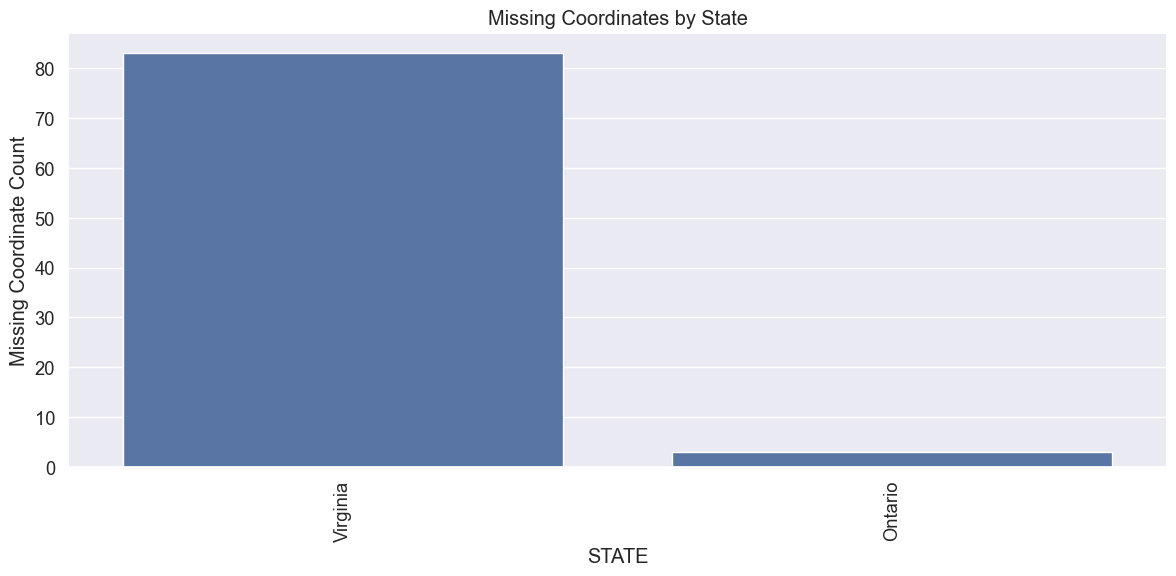

In [14]:
# Group by STATE to see distribution of missing coordinates
if not missing_coords_df.empty:
    state_summary = missing_coords_df['STATE'].value_counts().reset_index()
    state_summary.columns = ['STATE', 'Missing Coordinate Count']
    print("Distribution of missing coordinates by state:")
    print(state_summary)  # Add explicit print statement
    
    # Create a bar chart visualization of missing coordinates by state
    plt.figure(figsize=(12, 6))
    sns.barplot(x='STATE', y='Missing Coordinate Count', data=state_summary.sort_values('Missing Coordinate Count', ascending=False))
    plt.title('Missing Coordinates by State')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## 4. Check for Invalid Coordinate Values

In [17]:
# Make sure lat/lng are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for missing or invalid coordinates
missing_lat = df['Latitude'].isna()
missing_lng = df['Longitude'].isna()
invalid_lat = (df['Latitude'] < -90) | (df['Latitude'] > 90)
invalid_lng = (df['Longitude'] < -180) | (df['Longitude'] > 180)

# Combine to find all problematic coordinates
problematic_coords = missing_lat | missing_lng | invalid_lat | invalid_lng

# Create a new DataFrame with all problematic records
problematic_df = df[problematic_coords].copy()

# Add a column indicating the problem type
problematic_df['Problem Type'] = 'Multiple Issues'
problematic_df.loc[missing_lat & ~missing_lng & ~invalid_lng, 'Problem Type'] = 'Missing Latitude'
problematic_df.loc[~missing_lat & missing_lng & ~invalid_lat, 'Problem Type'] = 'Missing Longitude'
problematic_df.loc[missing_lat & missing_lng, 'Problem Type'] = 'Missing Both Coordinates'
problematic_df.loc[~missing_lat & ~missing_lng & invalid_lat & ~invalid_lng, 'Problem Type'] = 'Invalid Latitude'
problematic_df.loc[~missing_lat & ~missing_lng & ~invalid_lat & invalid_lng, 'Problem Type'] = 'Invalid Longitude'

print(f"Found {len(problematic_df)} records with problematic coordinates out of {len(df)} total records")
print(f"Percentage of records with problematic coordinates: {len(problematic_df) / len(df) * 100:.2f}%")

# Show a summary of problem types
problem_summary = problematic_df['Problem Type'].value_counts().reset_index()
problem_summary.columns = ['Problem Type', 'Count']
print("\nSummary of coordinate problems:")
print(problem_summary)

# Display problematic records
if not problematic_df.empty:
    cols_to_display = ['objectid', 'Location', 'Latitude', 'Longitude', 'STATE', 'County', 'Problem Type']
    display(problematic_df[cols_to_display].head(20))
    
    # Group by state to see distribution
    state_summary = problematic_df['STATE'].value_counts().reset_index()
    state_summary.columns = ['STATE', 'Problematic Coordinate Count']
    print("\nDistribution of problematic coordinates by state:")
    print(state_summary)

Found 86 records with problematic coordinates out of 17456 total records
Percentage of records with problematic coordinates: 0.49%

Summary of coordinate problems:
               Problem Type  Count
0  Missing Both Coordinates     86


,objectid,Location,Latitude,Longitude,STATE,County,Problem Type
4269,5124975,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4270,8342799,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4271,5127872,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4272,5125846,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4273,3964480,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4274,5125324,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4275,5125426,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4276,5149146,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4277,5095894,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates
4278,5127873,"""Bristol (independent city), Virginia, United ...",NaN,NaN,Virginia,"""Bristol (independent city)",Missing Both Coordinates



Distribution of problematic coordinates by state:
      STATE  Problematic Coordinate Count
0  Virginia                            83
1   Ontario                             3


## 5. Check for Duplicate Records

In [18]:
# Check for exact duplicates
exact_duplicates = df[df.duplicated()]
print(f"Found {len(exact_duplicates)} exact duplicate records")

# Check for potential duplicates based on location and date
location_date_duplicates = df[df.duplicated(subset=['Location', 'ObsDate', 'Latitude', 'Longitude'], keep=False)]
print(f"Found {len(location_date_duplicates)} potential duplicates based on location and date")

# Show some examples of potential duplicates
if not location_date_duplicates.empty:
    # Sort by location and date to group duplicates together
    location_date_duplicates = location_date_duplicates.sort_values(['Location', 'ObsDate'])
    location_date_duplicates[['objectid', 'Location', 'ObsDate', 'Latitude', 'Longitude', 'reporter']].head(10)

Found 0 exact duplicate records
Found 14 potential duplicates based on location and date


## 6. Visualize Coordinate Distribution

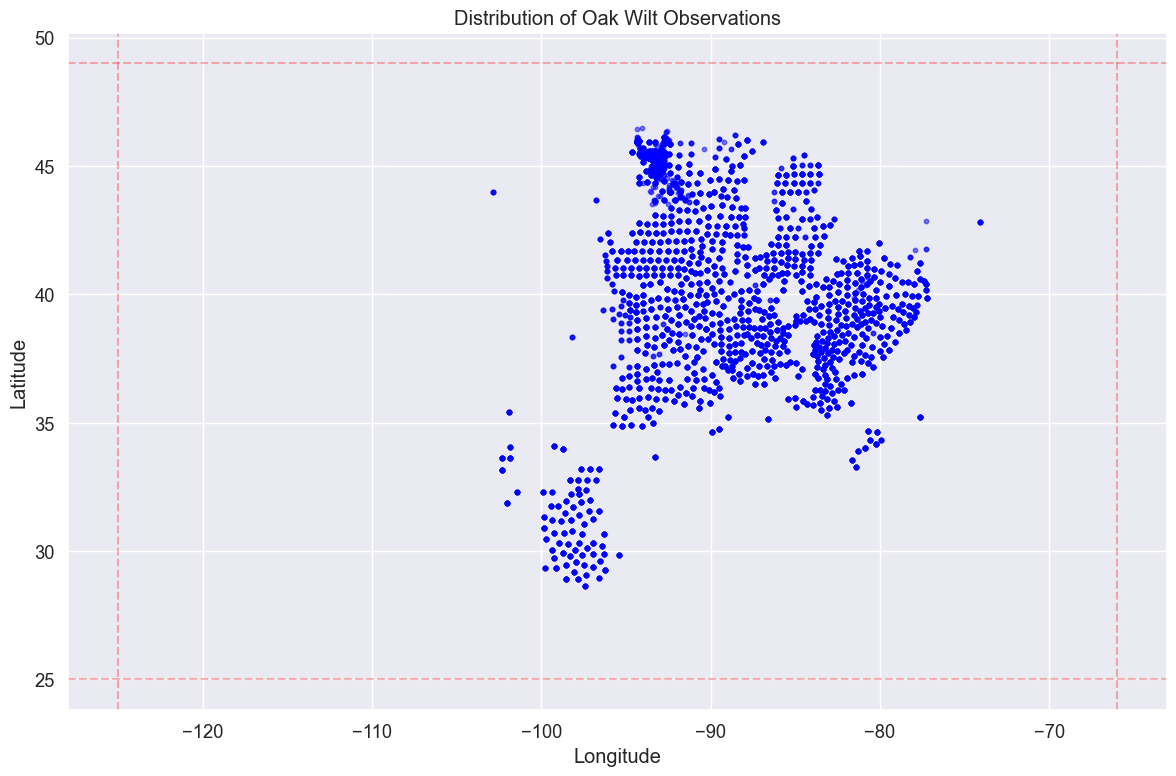

In [19]:
# Filter out records with missing coordinates
valid_coords = df.dropna(subset=['Latitude', 'Longitude'])

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(valid_coords['Longitude'], valid_coords['Latitude'], 
            alpha=0.5, c='blue', s=10)
plt.title('Distribution of Oak Wilt Observations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Add US rough boundaries for reference (approximate)
plt.axhline(y=25, color='red', linestyle='--', alpha=0.3)  # Southern US border
plt.axhline(y=49, color='red', linestyle='--', alpha=0.3)  # Northern US border
plt.axvline(x=-125, color='red', linestyle='--', alpha=0.3)  # Western US border
plt.axvline(x=-66, color='red', linestyle='--', alpha=0.3)   # Eastern US border

plt.tight_layout()
plt.show()

## 7. Check for Outliers in Coordinates

In [20]:
# Find outliers using IQR method
Q1_lat = valid_coords['Latitude'].quantile(0.25)
Q3_lat = valid_coords['Latitude'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat

Q1_lng = valid_coords['Longitude'].quantile(0.25)
Q3_lng = valid_coords['Longitude'].quantile(0.75)
IQR_lng = Q3_lng - Q1_lng

# Define outlier bounds
lat_lower_bound = Q1_lat - 1.5 * IQR_lat
lat_upper_bound = Q3_lat + 1.5 * IQR_lat
lng_lower_bound = Q1_lng - 1.5 * IQR_lng
lng_upper_bound = Q3_lng + 1.5 * IQR_lng

# Identify outliers
lat_outliers = (valid_coords['Latitude'] < lat_lower_bound) | (valid_coords['Latitude'] > lat_upper_bound)
lng_outliers = (valid_coords['Longitude'] < lng_lower_bound) | (valid_coords['Longitude'] > lng_upper_bound)
outliers = lat_outliers | lng_outliers

outliers_df = valid_coords[outliers]
print(f"Found {len(outliers_df)} potential coordinate outliers")

if not outliers_df.empty:
    outliers_df[['objectid', 'Location', 'Latitude', 'Longitude', 'STATE']].head(10)

Found 2646 potential coordinate outliers


## 8. State-by-State Summary

In [21]:
# Count records by state
state_counts = df['STATE'].value_counts().reset_index()
state_counts.columns = ['STATE', 'Record Count']

# Count records with valid coordinates by state
valid_coord_counts = valid_coords['STATE'].value_counts().reset_index()
valid_coord_counts.columns = ['STATE', 'Valid Coordinate Count']

# Merge the two counts
summary = state_counts.merge(valid_coord_counts, on='STATE', how='left')
summary['Valid Coordinate Count'] = summary['Valid Coordinate Count'].fillna(0).astype(int)
summary['Missing Coordinate Count'] = summary['Record Count'] - summary['Valid Coordinate Count']
summary['Missing Coordinate Percentage'] = (summary['Missing Coordinate Count'] / summary['Record Count'] * 100).round(2)

# Sort by record count
summary = summary.sort_values('Record Count', ascending=False)

summary

,STATE,Record Count,Valid Coordinate Count,Missing Coordinate Count,Missing Coordinate Percentage
0,Minnesota,9880,9880,0,0.00
1,Missouri,864,864,0,0.00
2,Illinois,801,801,0,0.00
3,Iowa,674,674,0,0.00
4,Ohio,665,665,0,0.00
5,Texas,619,619,0,0.00
6,Kentucky,618,618,0,0.00
7,Indiana,571,571,0,0.00
8,Wisconsin,485,485,0,0.00
9,West Virginia,448,448,0,0.00


## 9. Summary and Recommendations

In [22]:
# Generate recommendations
print("Data Quality Summary:")
print(f"Total records: {len(df)}")
print(f"Records with missing coordinates: {len(missing_coords_df)} ({len(missing_coords_df)/len(df)*100:.2f}%)")
print(f"Records with invalid coordinates: {len(invalid_coords_df)}")
print(f"Potential coordinate outliers: {len(outliers_df)}")
print(f"Exact duplicate records: {len(exact_duplicates)}")
print(f"Potential duplicate records: {len(location_date_duplicates)}")

print("\nRecommended data cleaning steps:")
recommendations = []

if len(missing_coords_df) > 0:
    recommendations.append(f"- Address {len(missing_coords_df)} records with missing coordinates")

if len(invalid_coords_df) > 0:
    recommendations.append(f"- Fix {len(invalid_coords_df)} records with invalid coordinate values")
    
if len(outliers_df) > 0:
    recommendations.append(f"- Review {len(outliers_df)} records with potential coordinate outliers")

if len(exact_duplicates) > 0:
    recommendations.append(f"- Remove {len(exact_duplicates)} exact duplicate records")
    
if len(location_date_duplicates) > 0:
    recommendations.append(f"- Review {len(location_date_duplicates)} potential duplicate records based on location and date")

for rec in recommendations:
    print(rec)
    
print("\nOnce these issues are addressed, the dataset will be ready for mapping and spatial analysis.")

Data Quality Summary:
Total records: 17456
Records with missing coordinates: 86 (0.49%)
Records with invalid coordinates: 0
Potential coordinate outliers: 2646
Exact duplicate records: 0
Potential duplicate records: 14

Recommended data cleaning steps:
- Address 86 records with missing coordinates
- Review 2646 records with potential coordinate outliers
- Review 14 potential duplicate records based on location and date

Once these issues are addressed, the dataset will be ready for mapping and spatial analysis.


## 10. Export Clean Dataset (Optional)

In [23]:
!pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.5 MB/s eta 0:00:0031m11.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 10.6 MB/s eta 0:00:0031m10.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [24]:
# Install if needed
# !pip install geopandas

import geopandas as gpd
from shapely.geometry import Point

# Create a clean dataset with only valid coordinates
clean_df = df.dropna(subset=['Latitude', 'Longitude']).copy()

# Convert coordinates to numeric
clean_df['Latitude'] = pd.to_numeric(clean_df['Latitude'], errors='coerce')
clean_df['Longitude'] = pd.to_numeric(clean_df['Longitude'], errors='coerce')

# Remove invalid coordinates
clean_df = clean_df[
    (clean_df['Latitude'] >= -90) & (clean_df['Latitude'] <= 90) & 
    (clean_df['Longitude'] >= -180) & (clean_df['Longitude'] <= 180)
]

# Remove duplicates
clean_df = clean_df.drop_duplicates()

print(f"Clean dataset has {len(clean_df)} records (removed {len(df) - len(clean_df)} problematic records)")

# Create geometry column
geometry = [Point(xy) for xy in zip(clean_df['Longitude'], clean_df['Latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(clean_df, geometry=geometry, crs="EPSG:4326")

# Save to shapefile
gdf.to_file('oak_wilt_clean.shp', driver='ESRI Shapefile')
print("Saved clean dataset to shapefile 'oak_wilt_clean.shp' with CRS EPSG:4326 (WGS 84)")

Clean dataset has 17370 records (removed 86 problematic records)
Saved clean dataset to shapefile 'oak_wilt_clean.shp' with CRS EPSG:4326 (WGS 84)


/Users/dynamicpacific/Dropbox/DEV/forestai-platform-model/oakwilt_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 0' to 'Unnamed_ 0'
  ogr_write(
/Users/dynamicpacific/Dropbox/DEV/forestai-platform-model/oakwilt_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'COUNTY' to 'COUNTY_1'
  ogr_write(
/Users/dynamicpacific/Dropbox/DEV/forestai-platform-model/oakwilt_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '"The DNR is not tracking oak wilt in Hennepin County, as it has been there for decades. I cannot rule out oak wilt from the photographs, but it looks more like Armillaria root disease or twolined chestnut borer, likely promoted by non-living prior  stress factors (e.g. compaction, construction damage).  These issues are very common. The only way to know if this bur oak had oak wilt would be to submit samples to the University of Minnesota d

Available columns in the dataset:
['Unnamed_ 0', 'KEY', 'objectid', 'reporter', 'RecOwner', 'SciName', 'ComName', 'Nativity', 'OccStatus', 'Status', 'ObsDate', 'DateEnt', 'DateUp', 'Location', 'County', 'COUNTY_1', 'STATE', 'Latitude', 'Longitude', 'Datum', 'Method', 'CoordAcc', 'DataType', 'Centroid', 'Abundance', 'InfestAcre', 'GrossAcre', 'Percentcov', 'Density', 'Quantity', 'QuantityU', 'APPXQuant', 'NumCollect', 'Smallest', 'Largest', 'Incidence', 'Severity', 'Host', 'Host_Name', 'HostPheno', 'HostDamage', 'ManageStat', 'PopStat', 'Habitat', 'LocalOwner', 'Site', 'RecBasis', 'Museum', 'MuseumRec', 'Voucher', 'ObsIDer', 'CollectTme', 'UUID', 'OrgSrcID', 'OrigName', 'RecSrcTyp', 'Surveyor', 'DateAcc', 'VisitType', 'DataMthd', 'TrapType', 'NumTraps', 'PID', 'WaterName', 'WaterType', 'Substrate', 'TreatArea', 'PlantTreat', 'TreatComm', 'Reference', 'Locality', 'Comments', 'ReviewDate', 'Reviewer', 'VerifyMthd', 'Verified', 'IDCred', 'ReviewComm', 'lat', 'lng', 'geometry']
Detected sta

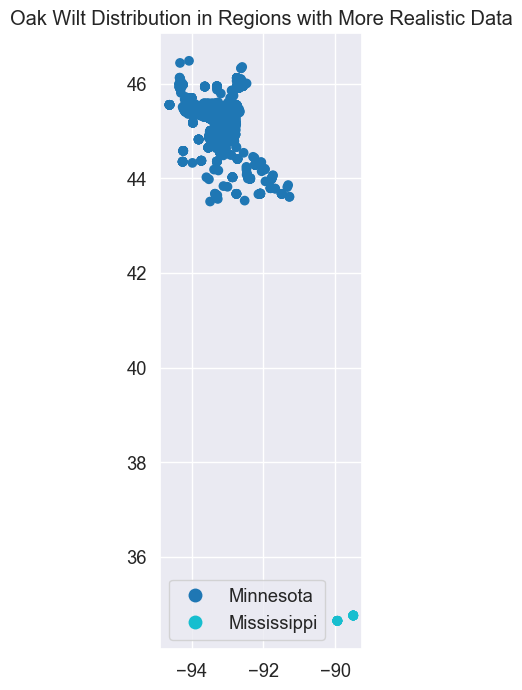

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the previously saved shapefile
gdf = gpd.read_file('oak_wilt_clean.shp')

# Create clean_df reference to the same data for consistency with your code
clean_df = gdf

# First, let's check what columns are available
print("Available columns in the dataset:")
print(clean_df.columns.tolist())

# Based on column names, determine which columns contain state and county information
# Adjust these variable names to match your actual column names
state_column = None
county_column = None

# Look for likely column names (case-insensitive)
for col in clean_df.columns:
    col_lower = col.lower()
    if 'state' in col_lower or 'province' in col_lower:
        state_column = col
    elif 'county' in col_lower or 'district' in col_lower:
        county_column = col

print(f"Detected state column: {state_column}")
print(f"Detected county column: {county_column}")

# If state and county columns were not automatically found, allow manual input
if state_column is None or county_column is None:
    print("\nPlease specify the column names for state and county information:")
    if state_column is None:
        print("Available columns:", clean_df.columns.tolist())
        state_column = input("Enter the column name that contains state information: ")
    if county_column is None:
        print("Available columns:", clean_df.columns.tolist())
        county_column = input("Enter the column name that contains county information: ")

# Now proceed with the analysis using the identified columns
# Count records by state
state_counts = clean_df[state_column].value_counts()
print("\nRecords per state/region:\n", state_counts)

# Count unique counties by state
counties_by_state = clean_df.groupby(state_column)[county_column].nunique()
print("\nUnique counties/districts per state/region:\n", counties_by_state)

# Calculate average points per county by state
points_per_county = clean_df.groupby(state_column).size() / counties_by_state
print("\nAverage points per county/district by state/region:\n", points_per_county.sort_values(ascending=False))

# Get the top 2 states with most points per county
top_states = points_per_county.sort_values(ascending=False).head(2).index.tolist()
print(f"\nTop 2 states/regions with most detailed data: {top_states}")

# Filter GeoDataFrame for those states
realistic_data = gdf[gdf[state_column].isin(top_states)]

# Create a map showing only these states
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
realistic_data.plot(ax=ax, column=state_column, legend=True)
ax.set_title('Oak Wilt Distribution in Regions with More Realistic Data')
plt.savefig('realistic_oak_wilt_map.png')
plt.show()

# Save only the realistic data to a new shapefile
# realistic_data.to_file('oak_wilt_realistic.shp', driver='ESRI Shapefile')


In [5]:
import geopandas as gpd

# Read the previously saved shapefile
gdf = gpd.read_file('oak_wilt_clean.shp')

# Display available columns to confirm state column name
print("Available columns in the dataset:")
print(gdf.columns.tolist())

# Look for state column (case-insensitive)
state_column = None
for col in gdf.columns:
    if 'state' in col.lower() or 'province' in col.lower():
        state_column = col
        break

# If state column wasn't found automatically, check unique values in columns
if state_column is None:
    print("\nCouldn't automatically identify state column.")
    print("Checking values in columns to find Minnesota data...")
    
    for col in gdf.columns:
        unique_values = gdf[col].unique()
        if len(unique_values) < 100:  # Only check columns with reasonable number of unique values
            if any('minnesota' in str(val).lower() for val in unique_values) or any('mn' in str(val).lower() for val in unique_values):
                state_column = col
                print(f"Found Minnesota values in column: {col}")
                print(f"Unique values: {gdf[col].unique()}")
                break

# If state column is found, use it to filter
if state_column:
    # Find the value that represents Minnesota
    mn_values = [val for val in gdf[state_column].unique() if 'minnesota' in str(val).lower() or 'mn' in str(val).lower()]
    
    if mn_values:
        mn_value = mn_values[0]
        print(f"Filtering for Minnesota (value: {mn_value})")
        minnesota_data = gdf[gdf[state_column] == mn_value]
    else:
        print(f"No Minnesota values found in column {state_column}.")
        print(f"Available values: {gdf[state_column].unique()}")
        mn_value = input("Enter the exact value that represents Minnesota: ")
        minnesota_data = gdf[gdf[state_column] == mn_value]
else:
    # Manual fallback if automatic detection fails
    print("\nCouldn't find state column. Please specify which column to use.")
    print("Available columns:", gdf.columns.tolist())
    state_column = input("Enter the column name that contains state information: ")
    
    print(f"Unique values in {state_column}:")
    print(gdf[state_column].unique())
    
    mn_value = input("Enter the exact value that represents Minnesota: ")
    minnesota_data = gdf[gdf[state_column] == mn_value]

# Save Minnesota data to a new shapefile
print(f"Extracted {len(minnesota_data)} records for Minnesota")
minnesota_data.to_file('oak_wilt_minnesota.shp', driver='ESRI Shapefile')
print("Saved Minnesota data to 'oak_wilt_minnesota.shp'")

# Print summary statistics
if county_column := next((col for col in gdf.columns if 'county' in col.lower()), None):
    counties = minnesota_data[county_column].nunique()
    print(f"Data covers {counties} counties in Minnesota")
    print(f"Average of {len(minnesota_data)/counties:.1f} points per county")

Available columns in the dataset:
['Unnamed_ 0', 'KEY', 'objectid', 'reporter', 'RecOwner', 'SciName', 'ComName', 'Nativity', 'OccStatus', 'Status', 'ObsDate', 'DateEnt', 'DateUp', 'Location', 'County', 'COUNTY_1', 'STATE', 'Latitude', 'Longitude', 'Datum', 'Method', 'CoordAcc', 'DataType', 'Centroid', 'Abundance', 'InfestAcre', 'GrossAcre', 'Percentcov', 'Density', 'Quantity', 'QuantityU', 'APPXQuant', 'NumCollect', 'Smallest', 'Largest', 'Incidence', 'Severity', 'Host', 'Host_Name', 'HostPheno', 'HostDamage', 'ManageStat', 'PopStat', 'Habitat', 'LocalOwner', 'Site', 'RecBasis', 'Museum', 'MuseumRec', 'Voucher', 'ObsIDer', 'CollectTme', 'UUID', 'OrgSrcID', 'OrigName', 'RecSrcTyp', 'Surveyor', 'DateAcc', 'VisitType', 'DataMthd', 'TrapType', 'NumTraps', 'PID', 'WaterName', 'WaterType', 'Substrate', 'TreatArea', 'PlantTreat', 'TreatComm', 'Reference', 'Locality', 'Comments', 'ReviewDate', 'Reviewer', 'VerifyMthd', 'Verified', 'IDCred', 'ReviewComm', 'lat', 'lng', 'geometry']
Filtering fo